### MScFE 690 Capstone -- Final Submission

### 1. Imports

In [1]:
import nolds
import pandas as pd
import numpy as np
import math
from fbm import *
from fbm import FBM
import yfinance as yf
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'arial'
import warnings
#from pandas.core.common import SettingWithCopyWarning
#warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
from sklearn.exceptions import UndefinedMetricWarning
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)
def filter_ransac_warning(message, category, filename, lineno, file=None, line=None):
    return "RANSAC did not reach consensus" not in str(message)
warnings.filterwarnings("ignore", message=".*RANSAC did not reach consensus.*", category=RuntimeWarning)

The MMAR or Multifractal Model of Asset Returns utilizes a compound process denoted as \(X(t)\). This is presented mathematically as:

$$ X(t) = B_H(\theta(t)) $$

Here are the components of the equation:

- \(X(t)\) is our compound process. This signifies the cumulative effect of multiple time scales.
- \(B_H(t)\) is what we call a fractional Brownian motion. This is a variation of a Gaussian process and a generalization of the standard Brownian motion. The Hurst exponent, denoted by \(H\) (with \(0 < H < 1\)), characterizes this motion. A Hurst exponent of \(0.5\) turns \(B_H(t)\) into a standard Brownian motion, while a Hurst exponent less than \(0.5\) indicates negative correlation in the process increments, and a Hurst exponent greater than \(0.5\) suggests positive correlation.
- Lastly, \($\theta(t)$\) corresponds to the cumulative distribution function of a specific multifractal cascade measure. This is crucial as it dictates the changing "pace" of the fractional Brownian motion. The precise form of \($\theta(t)$\) is contingent on the multifractal cascade measure in use, which itself depends on the distinct properties of the financial time series under study.

### 2. A Look a Fractal Brownian Motion

#### 2.1. Simple FBM Simulation using Nolds

Fractional Brownian Motion can be described as a "walk" where the next step might be influenced by previous steps. This could be for example in the form of momentum or reversion. This introduction of "memory" via the hurst exponent aims to model this well-known memory feature of financial markets. FBM is compontent of the MMAR that will be described in the following sections.

In [2]:
fbm = nolds.fbm(100, H=0.75)

In [3]:
fbm = pd.Series(fbm)

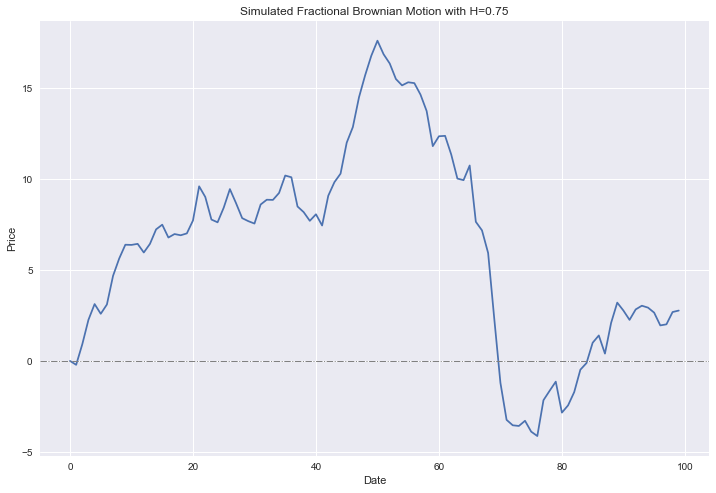

In [4]:
plt.figure(figsize=(12, 8))
plt.plot(fbm)
plt.axhline(y=0.0, color='grey', linestyle='-.', linewidth=1)
plt.title('Simulated Fractional Brownian Motion with H=0.75')
# plt.legend(loc=0)
plt.xlabel('Date')
plt.ylabel('Price')
# plt.savefig('fbm_sim_h075.png')
plt.show()

#### 2.2. Importing Oil Prices

In [73]:
ticker_symbol = 'CL=F'
start_date = '1990-01-01'
end_date = '2023-06-30'
data = yf.download(ticker_symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [74]:
prices = data['Adj Close']
prices_fixed = prices.copy()

In [75]:
prices.describe()

count    5737.000000
mean       63.828126
std        25.614463
min       -37.630001
25%        44.480000
50%        61.450001
75%        83.629997
max       145.289993
Name: Adj Close, dtype: float64

In [76]:
prices

Date
2000-08-23    32.049999
2000-08-24    31.629999
2000-08-25    32.049999
2000-08-28    32.869999
2000-08-29    32.720001
                ...    
2023-06-26    69.370003
2023-06-27    67.699997
2023-06-28    69.559998
2023-06-29    69.860001
2023-06-30    70.639999
Name: Adj Close, Length: 5737, dtype: float64

#### 2.3. The Hurst Exponent: Calculating Oil's Hurst Exponent

The Hurst exponent \(H\) is a statistical measure used to classify time series data. It can help in determining the nature of a given time series:

- \(H < 0.5\): The time series has a tendency to revert to a mean (negative autocorrelation).
- \(H = 0.5\): The time series follows a random walk (Brownian motion).
- \(H > 0.5\): The time series shows a persistent behavior (positive autocorrelation).

However, different lenghts of timeseries should generate different values of Hurst Exponent. This is due to the fact that the same underlying process (i.e the positive or negative autocorrelation present in the timeseries) can appear differently under different sampling sizes or resolutions. 

One solution is the one proposed below, where the price data is divided into segments and several calculations of H generating a distribution. 

In [8]:
def segment_data(data, num_segments):
    """
    Splits the data into multiple segments.
    """
    len_segment = len(data) // num_segments
    return [data[i:i+len_segment] for i in range(0, len(data), len_segment) if len(data[i:i+len_segment]) == len_segment]

def calculate_hurst_for_segments(data, num_segments):
    """
    Calculate the Hurst exponent for the segment
    """
    segments = segment_data(data, num_segments)
    hurst_values = [nolds.hurst_rs(seg) for seg in segments]
    return hurst_values

num_segments = 625
hurst_values = calculate_hurst_for_segments(prices, num_segments)

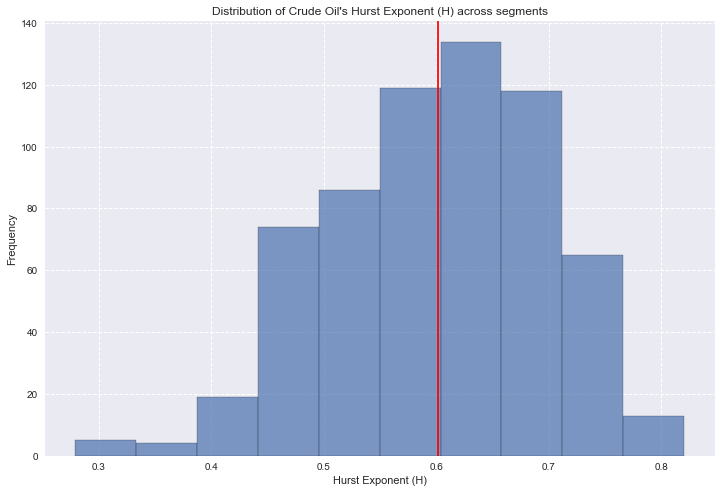

In [9]:
plt.figure(figsize=(12, 8))
plt.hist(hurst_values, bins=10, edgecolor='black', alpha=0.7)
plt.title("Distribution of Crude Oil's Hurst Exponent (H) across segments")
plt.xlabel("Hurst Exponent (H)")
plt.ylabel("Frequency")
plt.axvline(np.mean(hurst_values), color='red')
plt.grid(True, which="both", ls="--")
plt.savefig('dist_oil_h.png')
plt.show()

In [10]:
np.mean(hurst_values)

0.6012417804833374

In [11]:
h_oil = np.mean(hurst_values)

Crude Oil's Hurst Exponenet is seen centered around 0.60, i.e small persistence autocorrelation.

#### 2.4. Simulating A FBM with Oil's H

In [12]:
fbm_oil = nolds.fbm(100, H=np.mean(hurst_values))

In [13]:
fbm_oil = pd.Series(fbm_oil)

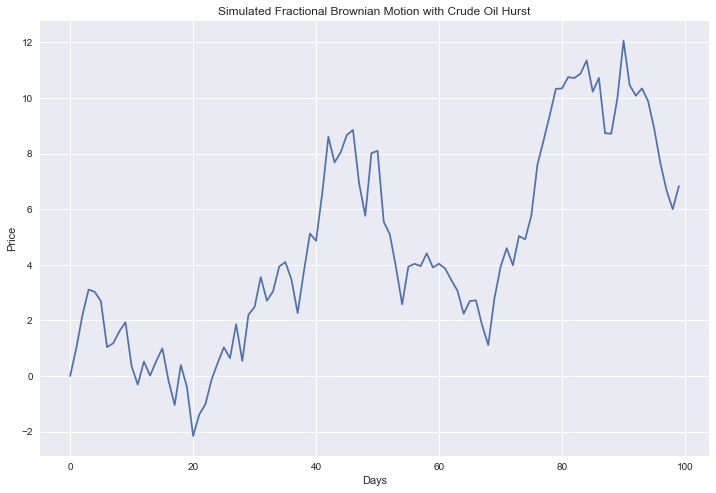

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(fbm_oil)
#plt.axhline(y=0.0, color='grey', linestyle='-.', linewidth=1)
plt.title('Simulated Fractional Brownian Motion with Crude Oil Hurst')
# plt.legend(loc=0)
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

We can see from the above simulation that for any realistic simulation of prices using a FBM, we would need to include a limitation for prices going negative (even though oil prices did go negative in the past!).

To examplify the process of pricing an option using Monte Carlo simulation from a given stochastic model, we will attempt to price an European call option under the assumption that the price of the asset follows a fractional Brownian Motion process (fbm). We will later use the same methodology to calculate the payoff and discounted value for the MMAR simulations:

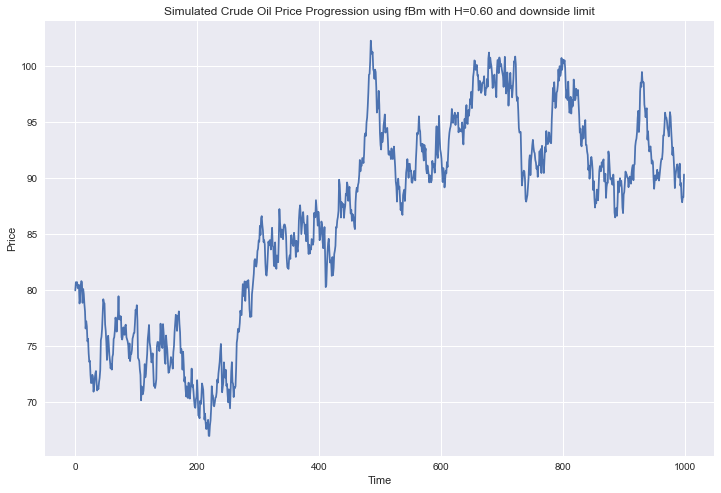

In [15]:
def generate_fbm_path(n, hurst, dt=1, s0=1):
    """Generate a fractional Brownian motion path with n steps and a given Hurst exponent."""
    # Generate Fractional Gaussian Noise using numpy's random.randn
    dW = np.random.randn(n)
    
    # Generate the fBm increments (scales with time as per Hurst exponent)
    increments = dW * (dt**(hurst))
    
    # Construct the fBm path
    fbm_path = np.cumsum(increments)
    
    # Shift the path to start at s0
    fbm_path = fbm_path - fbm_path[0] + s0
    
    return fbm_path

n = 1000  # number of steps
hurst_mean = np.mean(hurst_values)  # Mean Hurst value calculated from earlier
prices = generate_fbm_path(n, hurst_mean, s0=80)

# Imposing floor to ensure prices don't go below 0
prices = np.where(prices > 0, prices, 0)

# Plot the simulated prices
plt.figure(figsize=(12, 8))
plt.plot(prices)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'Simulated Crude Oil Price Progression using fBm with H={hurst_mean:.2f} and downside limit')
plt.grid(True)
#plt.savefig('oil_fbm_downside_s0.png')
plt.show()

The simulation above we introduced s0 = 80 (where crude oil is roughly trading currently) and a downside limitation to prices.  

#### 2.5. Pricing Oil Options with FBM and Monte Carlo

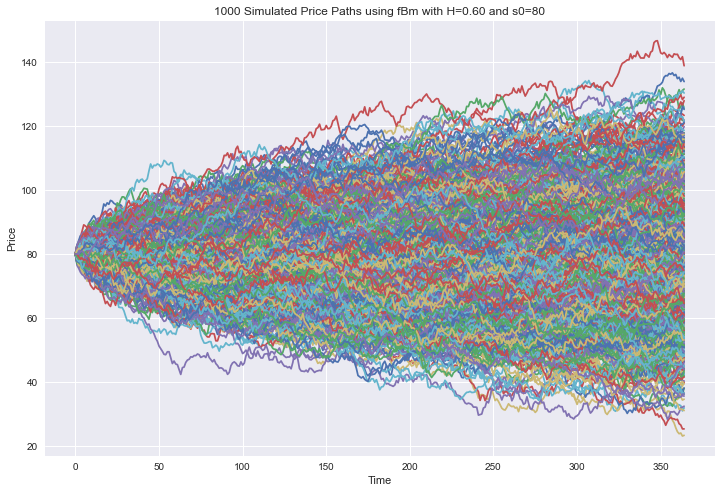

In [16]:
def generate_multiple_paths(num_paths, n, hurst, dt=1, s0=1):
    """Generate multiple fBm paths and plot them."""
    # Create a new plot
    plt.figure(figsize=(12, 8))
    
    # For each path
    for _ in range(num_paths):
        prices = generate_fbm_path(n, hurst, dt, s0)
        # Imposing floor to ensure prices don't go below 0
        prices = np.where(prices > 0, prices, 0)
        plt.plot(prices)
    
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(f'{num_paths} Simulated Price Paths using fBm with H={hurst:.2f} and s0={s0}')
    plt.grid(True)
    plt.savefig('oil_fbm_sim_paths_s0.png')
    plt.show()

num_paths = 1000 
n = 365  # Number of steps per path
hurst_mean = np.mean(hurst_values)  # Mean Hurst value calculated from earlier
s0 = 80  # Starting price
generate_multiple_paths(num_paths, n, hurst_mean, s0=s0)

In [17]:
# Re-defining 'generate_multiple_paths' without the charting functionality
def generate_multiple_paths(num_paths, n, hurst, dt=1, S0=1):
    """Generate multiple fBm paths."""
    paths = []
    for _ in range(num_paths):
        prices = generate_fbm_path(n, hurst, dt, S0)
        # Imposing floor to ensure prices don't go below 0
        prices = np.where(prices > 0, prices, 0)
        paths.append(prices)
    return paths

def monte_carlo_option_price(num_paths, n, hurst, dt=1, S0=1, r=0.05, T=1, option_type="call", K=None):
    """Compute European option price using Monte Carlo simulation."""
    if K is None:
        K = S0  # If no strike is provided, assume ATM
    
    total_payoff = 0
    
    # Generate multiple price paths
    paths = generate_multiple_paths(num_paths, n, hurst, dt, S0)
    
    # Calculate total payoff from all paths
    for prices in paths:
        ST = prices[-1]  # Price at expiration
        
        # Payoff calculation
        if option_type == "call":
            payoff = max(ST - K, 0)  # Payoff of European call option
        elif option_type == "put":
            payoff = max(K - ST, 0)  # Payoff of European put option
        else:
            raise ValueError("Option type must be 'call' or 'put'")
        
        total_payoff += payoff
    
    # Average payoff
    average_payoff = total_payoff / num_paths
    
    # Discount the average payoff to get option price
    option_price = average_payoff * np.exp(-r * T)
    
    return option_price

# Usage example
num_paths = 1000
n = 252  # Assuming daily steps for a year
hurst_mean = np.mean(hurst_values)
S0 = 80
r = 0.05
T = 1
K = 80  # Strike price

call_price = monte_carlo_option_price(num_paths, n, hurst_mean, S0=S0, r=r, T=T, option_type="call", K=K)
put_price = monte_carlo_option_price(num_paths, n, hurst_mean, S0=S0, r=r, T=T, option_type="put", K=K)

print(f"European Call Option Price (Strike {K}): ${call_price:.2f}")
print(f"European Put Option Price (Strike {K}): ${put_price:.2f}")

European Call Option Price (Strike 80): $6.05
European Put Option Price (Strike 80): $6.27


We can see from the implied option prices in the market current (picture attached) that the 1year ATM call option price for WTI is currently at $8.8;
This model is underpricing the option relatively to the market.

### 3. The Multifractal Model of Asset Returns

#### 3.1. The Multiplicative Cascade Process

A vital part of the Multifractal Model of Asset Returns (MMAR) is the multiplicative cascade process, which produces the multifractal measure. This process can be illustrated mathematically as:

$$ \theta(t) = \prod_{i=1}^{k} x_i $$

Here, each \( $x_i$ \) is an independent and identically distributed random variable, and \( k \) represents the number of steps in the cascade process. The exact distribution of \( $x_i$ \) will be contingent on the specific traits of the financial time series under analysis.

Another distinguishing attribute of the MMAR is its capability to simulate several statistical properties observed in financial returns, such as heavy tails and volatility clustering. These characteristics can be embodied by the autocorrelation function of the absolute returns, which can be estimated as:

$$ Corr(|r_t|, |r_{t+\tau}|) \approx C \tau^{2H-2} $$

In this equation, \( C \) is a constant, \( $\tau$ \) is the time lag, and \( H \) is the Hurst exponent.

Put simply, the multiplicative cascade is a process where at each stage of the cascade (subdivision or step), a given quantity is multiplied by a factor to produce the quantities for the next layer. The process is an iterative one, creating a hierarchy or cascade of multiplications. In the context of fractals, the Multiplicative Cascade helps to produce a measure that shows multifractal properties. This is because different parts of the data will have different scaling behaviors in result of the cascade multiplication which creates a complex and multifractal structure. 

Below we will explore a few options for generating multifractal processes with the multiplicative cascade methodology. 

#### 3.2. Simplified Model with Multiplicative Cascade

In the section below, we attempt to use a simplified MMAR model implementing a multifractal measure with multiplicative cascade.

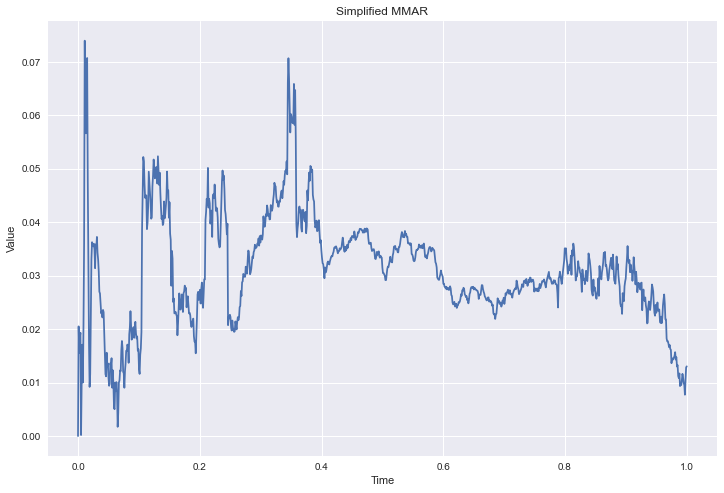

In [18]:
def generate_multifractal_measure(hurst, num_intervals):
    """
    This function generates a multifractal measure using a multiplicative cascade.
    The weights of the subintervals are correlated, and their correlation is controlled by the Hurst parameter.
    """
    
    # Initialize measure with one interval [0, 1]
    measure = [(0, 1)]
    
    for _ in range(num_intervals):
        # Choose a random interval from measure
        index = np.random.randint(len(measure))
        a, b = measure.pop(index)
        
        # Choose a random point in the interval according to Beta distribution
        split_point = np.random.beta(a=hurst, b=hurst)
        
        # Add new intervals to measure
        measure.append((a, a + split_point * (b - a)))
        measure.append((a + split_point * (b - a), b))
    
    # Sort measure by interval start time
    measure.sort(key=lambda x: x[0])
    
    return measure

def generate_MMAR(hurst, num_intervals, mu, sigma, T, N):
    """
    This function generates a time series using the MMAR.
    """
    
    # Generate multifractal measure
    measure = generate_multifractal_measure(hurst, num_intervals)
    
    # Initialize MMAR
    MMAR = np.zeros(N)
    dt = T/N
    time_stamps = np.linspace(0, T, N)
    
    # Apply measure to time series
    for i in range(1, N):
        for a, b in measure:
            if a <= time_stamps[i] < b:
                MMAR[i] = MMAR[i-1] + np.sqrt(dt / (b - a)) * np.random.normal(mu * dt, sigma * np.sqrt(dt))
        
        # Correction step to ensure MMAR doesn't go negative
        if MMAR[i] < 0:
            MMAR[i] = 0.01  # Correcting to a small positive value
    
    return MMAR


# Set the parameters
hurst = 0.60
num_intervals = 252
mu = 0.1
sigma = 0.40
T = 1
N = 1000

# Generate MMAR
MMAR = generate_MMAR(hurst, num_intervals, mu, sigma, T, N)

# Plot the MMAR
plt.figure(figsize=(12, 8))
plt.plot(np.linspace(0, T, N-1), MMAR[:-1])
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Simplified MMAR')
plt.show()

With this model, we are able to produce price charts that resemble real asset asset prices, but that are not realistic enough just yet. We make the following simplifications relatively to the MMAR:  
  
1 - Mandelbrot's MMAR employs a much more intricate procedure for the multifractal measure construction, using binomial cascades to generate a range of measures.   
2 - In Mandelbrot's MMAR, volatility is governed by trading time which evolves in a multifractal fashion while this model only applies the cascade to regular calendar time.  
3 - MMAR involves several more parameters to capture various features of timeseries behavior.  
4 - MMAR does not inherently prevent prices from going negative (like we are doing here).  

#### 3.3. An Attempt at a More Sophisticated Multifractal Generator

Now, for a slightly more realistic representation, we'll add the parameters alpha and beta to the multifractal measure, making sure that the interval weights are influenced by H, making the model more sensitive to long-term memory. We'll also implement time-varying volatility, as a function of trading time, similar to what is proposed by the MMAR. 

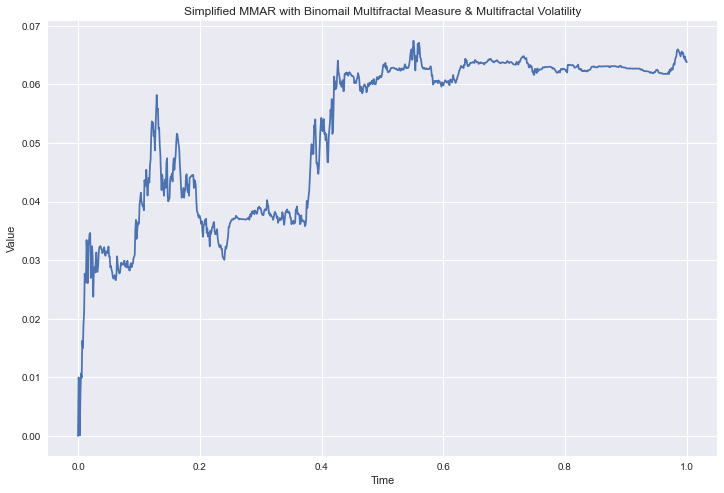

In [26]:
def generate_multifractal_measure_binomial(hurst, num_intervals):
    """
    This function generates a binomial multifractal measure using a multiplicative cascade.
    """
    alpha = 0.5 + hurst / 2
    beta = 0.5 - hurst / 2
    
    # Initialize measure with one interval [0, 1] and weight 1
    measure = [(0, 1, 1)]
    
    for _ in range(num_intervals):
        # Choose a random interval from measure
        index = np.random.randint(len(measure))
        a, b, w = measure.pop(index)
        
        # Generate a binomial random variable
        p = np.random.binomial(n=1, p=0.5)
        
        # Calculate new weights
        w_alpha = w * alpha if p == 1 else w * beta
        w_beta = w * beta if p == 1 else w * alpha
        
        # Add new intervals to measure
        measure.append((a, a + 0.5 * (b - a), w_alpha))
        measure.append((a + 0.5 * (b - a), b, w_beta))
    
    # Sort measure by interval start time
    measure.sort(key=lambda x: x[0])
    
    return measure

def generate_MMAR_binomial(hurst, num_intervals, mu, sigma, T, N, S0):
    """
    This function generates a time series using the MMAR, with volatility as a function of the trading time.
    """
    # Generate multifractal measure
    measure = generate_multifractal_measure_binomial(hurst, num_intervals)
    
    # Initialize MMAR
    MMAR = np.zeros(N)
    MMAR[0] = S0
    dt = T / N
    time_stamps = np.linspace(0, T, N)
    
    # Apply measure to time series
    for i in range(1, N):
        for a, b, w in measure:
            if a <= time_stamps[i] < b:
                dW = np.random.normal(0, np.sqrt(dt))
                volatility = sigma * np.sqrt(w)
                MMAR[i] = MMAR[i-1] + mu * w * dt + volatility * dW
        # Correction step to ensure MMAR doesn't go negative
        if MMAR[i] < 0:
            MMAR[i] = 0.01  # Correcting to a small positive value
        
    return MMAR

# Set the parameters
hurst = 0.60
num_intervals = 252
mu = 0.1
sigma = 30
T = 1
N = 1000
S0 = 80

# Generate the simplified MMAR
MMAR_paths = generate_MMAR_binomial(hurst, num_intervals, mu, sigma, T, N, S0=80)

# Plot the MMAR
plt.figure(figsize=(12, 8))
plt.plot(np.linspace(0, T, N-1), MMAR[:-1])
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Simplified MMAR with Binomail Multifractal Measure & Multifractal Volatility')
#plt.savefig('simple_mmar_mfm_mfv.png')
plt.show()

Now we'll use the same model above to generate several paths:

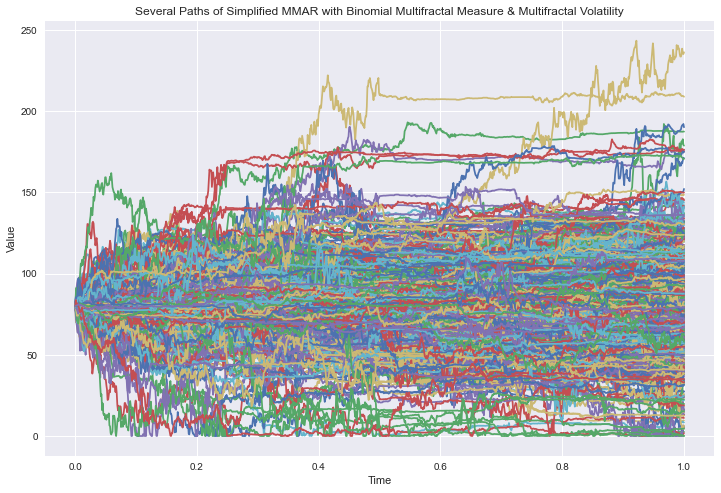

Wall time: 42.2 s


In [106]:
%%time
def generate_MMAR_binomial(hurst, num_intervals, mu, sigma, T, N, S0, num_paths=1):
    """
    This function generates multiple time series using the MMAR, with volatility as a function of the trading time.
    """
    paths = []

    for _ in range(num_paths):
        # Generate multifractal measure
        measure = generate_multifractal_measure_binomial(hurst, num_intervals)
        
        # Initialize MMAR
        MMAR = np.zeros(N)
        MMAR[0] = S0
        dt = T / N
        time_stamps = np.linspace(0, T, N)
        
        # Apply measure to time series
        for i in range(1, N):
            for a, b, w in measure:
                if a <= time_stamps[i] < b:
                    dW = np.random.normal(0, np.sqrt(dt))
                    volatility = sigma * np.sqrt(w)
                    MMAR[i] = MMAR[i-1] + mu * w * dt + volatility * dW
        
            # Correction step to ensure MMAR doesn't go negative
            if MMAR[i] < 0:
                MMAR[i] = 0.01  # Correcting to a small positive value

        paths.append(MMAR)

    return paths

# Set the parameters
hurst = 0.60
num_intervals = 252
mu = 0.001 # assuming very small drift
sigma = 0.40
sigma_adj = sigma * 400
T = 1
N = 1000
S0 = 80
num_paths = 1000

# Generate the simplified MMAR
MMAR_paths = generate_MMAR_binomial(hurst, num_intervals, mu, sigma_adj, T, N, S0, num_paths)

# Plot the MMAR
plt.figure(figsize=(12, 8))
for path in MMAR_paths:
    plt.plot(np.linspace(0, T, N-1), path[:-1])
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Several Paths of Simplified MMAR with Binomial Multifractal Measure & Multifractal Volatility')
plt.savefig('simple_mmar_mfm_mfv_paths.png')
plt.show()

After producing some simplified versions of the model to illustrate its workings and main components, we will use Crude Oil's data to calculate the necessary parameters for a yet more realistic version of the MMAR proposed by Mandelbrot, using the parameters found in the real data. 

### 4. Calculating the necessary Fractal Parameters for the Simulations

The steps to calculate the fractal parameters are as follows:

1. Get a highly composite number of data points (7560 in this case)
2. Generate $\Delta t$ (or $dt$) which are the time increments
3. Generate the statistical moments $q$ that will be used for the partition function.
4. Calculate the partition function for different values of $dt$ and $q$
5. Calculate the scaling function $\tau_q$ (the regressions of the partition functions). Use lower moments. 
6. Estimate the precise value of $H$
7. Calculate $\alpha_0$
8. Calculate $\lambda$ and $\sigma^2$

#### 4.1. Obtain and Format Data

In [79]:
prices_data = prices_fixed.copy()

In [80]:
close_return = prices_data.copy()
close_return.loc[close_return < 0] = 0.0001
close_return = np.log(close_return/close_return.shift())
close_return = close_return.dropna()

In [81]:
prices_data_train = prices.iloc[:-252]
prices_data_test = prices.iloc[-252:]

close_return_train = close_return.iloc[:-252]
close_return_test = close_return.iloc[-252:]

#### 4.2. Raw Statistical Moments

In [138]:
# Define the sequence ranges
# Select the values of q
# The q here

q = np.linspace(0.01, 3, 120) # up to a value with a quadratic shape
q

array([0.01      , 0.03512605, 0.0602521 , 0.08537815, 0.1105042 ,
       0.13563025, 0.1607563 , 0.18588235, 0.2110084 , 0.23613445,
       0.2612605 , 0.28638655, 0.31151261, 0.33663866, 0.36176471,
       0.38689076, 0.41201681, 0.43714286, 0.46226891, 0.48739496,
       0.51252101, 0.53764706, 0.56277311, 0.58789916, 0.61302521,
       0.63815126, 0.66327731, 0.68840336, 0.71352941, 0.73865546,
       0.76378151, 0.78890756, 0.81403361, 0.83915966, 0.86428571,
       0.88941176, 0.91453782, 0.93966387, 0.96478992, 0.98991597,
       1.01504202, 1.04016807, 1.06529412, 1.09042017, 1.11554622,
       1.14067227, 1.16579832, 1.19092437, 1.21605042, 1.24117647,
       1.26630252, 1.29142857, 1.31655462, 1.34168067, 1.36680672,
       1.39193277, 1.41705882, 1.44218487, 1.46731092, 1.49243697,
       1.51756303, 1.54268908, 1.56781513, 1.59294118, 1.61806723,
       1.64319328, 1.66831933, 1.69344538, 1.71857143, 1.74369748,
       1.76882353, 1.79394958, 1.81907563, 1.84420168, 1.86932

In [139]:
from IPython.display import display, HTML

display(HTML("<style>div.output_scroll { height: auto; }</style>"))

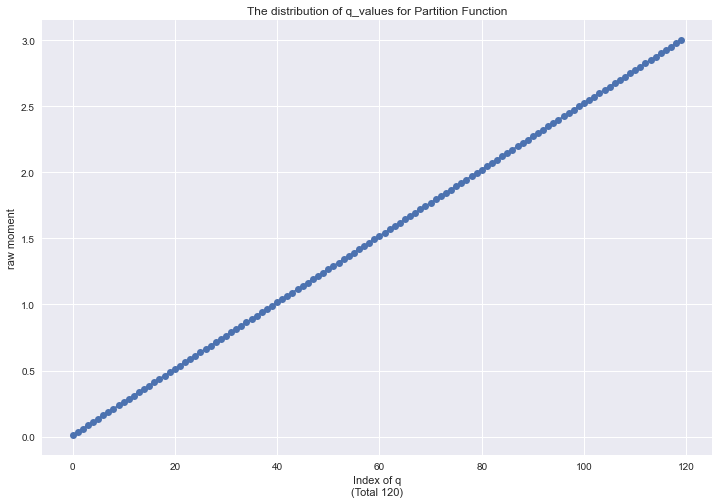

In [140]:
# Plotting q_values
plt.figure(figsize=(12,8))
plt.grid(True)
plt.title("The distribution of q_values for Partition Function")
plt.xlabel(f"Index of q\n(Total {len(q)})")
plt.ylabel('raw moment')
plt.plot(q, marker='o')
plt.savefig('dist_q_values.png')
plt.show()

#### 4.3. Partition Function

In summary, the Chhabra-Jensen method uses the partition function to characterize scaling behavior and then Legendre transforms this to derive the multifractal spectrum.

In [141]:
min_window = 10
max_window = len(prices_data_train)
print('length of the training prices data: ', len(prices_data_train))

window_sizes = list(map(
        lambda x: int(10**x),
        np.arange(math.log10(min_window), math.log10(max_window), 0.25)))
window_sizes

length of the training prices data:  5484


[10, 17, 31, 56, 100, 177, 316, 562, 1000, 1778, 3162]

In [142]:
def partition_function(delta, x_t, q):
    '''
    @params
    delta array: time interval range
    x_t array: the time series
    q float: the power q
    
    @returns
    Fq pd.DataFrame: the partition function values for different delta and q
    '''
    # Initialize a 2D array sigma to store the partition function values.
    # row for different delta
    Fq = [[0 for x in range(len(delta))] for y in range(len(q))]
    
    # Loop through each exponent q[k] and time lag delta[j].
    # For each q and delta, compute the partition function by:
    # i) Iterating through the time series in chunks of size delta[j]
    # ii) Calculating the absolute difference between each point and the point delta[j] steps ahead
    # iii) Summing the q[k] power of these differences
    for k in range (0, len(q)):
        if k%30==0: # dividable by 30
            print("calculating q=" + str(k) + ' out of ' + str(len(q)-1))
            
        for j in range (0,len(delta)):
            
            for i in range (0,len(x_t)-1):
                if i < int((len(x_t)-1)/delta[j]):
                    Fq[k][j]=Fq[k][j] + abs(x_t[i*delta[j]+delta[j]]-x_t[i*delta[j]])**q[k]

    Fq=pd.DataFrame(Fq)

    for i in range(0,len(q)):
        Fq.rename(index={Fq.index[i]:q[i]}, inplace=True)
    for i in range(len(delta)-1,-1,-1):
        Fq.rename(columns={Fq.columns[i]:delta[i]}, inplace=True)

    print("Finished. Return Fq...")
    return Fq

In [143]:
Fq = partition_function(window_sizes, prices_data_train, q)

calculating q=0 out of 119
calculating q=30 out of 119
calculating q=60 out of 119
calculating q=90 out of 119
Finished. Return Fq...


In [144]:
Fq

,10,17,31,56,100,177,316,562,1000,1778,3162
0.010000,552.056061,325.355865,178.322583,98.499667,54.952130,3.067427e+01,17.437381,9.226065,5.123352,3.039287,1.042018
0.035126,562.681122,334.110304,184.398375,102.438588,57.461319,3.246639e+01,18.597113,9.826753,5.457136,3.147290,1.155550
0.060252,573.941180,343.341353,190.830815,106.633670,60.145831,3.440740e+01,19.849587,10.477337,5.827548,3.269415,1.281453
0.085378,585.855654,353.069247,197.637484,111.100638,63.016645,3.650913e+01,21.202611,11.182051,6.238002,3.406792,1.421072
0.110504,598.445624,363.315619,204.837252,115.856513,66.085728,3.878450e+01,22.664685,11.945499,6.692271,3.560675,1.575904
...,...,...,...,...,...,...,...,...,...,...,...
2.899496,103155.361592,135905.823932,136097.571369,303456.986041,476406.027663,8.185898e+05,315041.455730,147667.760342,348991.279471,80454.231300,152384.069927
2.924622,110174.967348,146185.179638,146452.061637,331206.452979,527456.343853,9.106949e+05,346270.784065,161985.465628,387460.482220,88721.235774,168986.951300
2.949748,117707.609202,157283.058587,157621.828491,361547.986472,584083.286791,1.013329e+06,380618.895717,177704.932738,430184.897319,97838.058881,187398.785997
2.974874,125792.832839,169267.055756,169672.761070,394727.662289,646904.431396,1.127711e+06,418399.071525,194964.571623,477636.514939,107892.072756,207816.667044


In [145]:
# Power-law regression on log Fq(q, delta) vs log delta to get scaling exponent τ(q)
# If the signal has scaling properties, Fq will follow a power law:
# Fq ~ delta^τ(q)
tau_q_list = []
for i,row in Fq.iterrows():
    Fq_matrix = np.vstack([np.log10(row.values), np.ones(len(row))]).T
    tau_q, c = np.linalg.lstsq(Fq_matrix, np.log10(window_sizes), rcond=-1)[0]
    tau_q_list.append(tau_q)

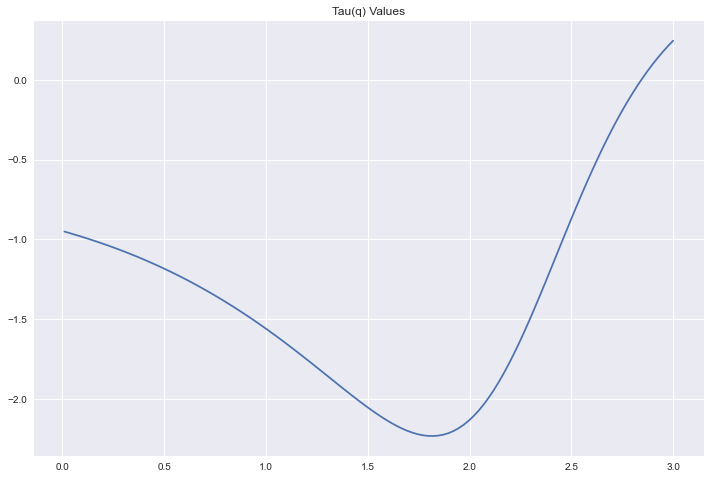

In [146]:
# plot τ(q) with q
# Monofractal signals show a linear τ(q) curve. The slope gives the single Hurst exponent H.
# Multifractal τ(q) curves are nonlinear. The curvature reveals richer structure.
plt.figure(figsize=(12, 8))
y = np.array(Fq.index)
plt.plot(y, tau_q_list)
plt.title('Tau(q) Values')
# plt.savefig('tau_values.png')
plt.show()

#### 4.4. The Hurst Exponent H

In [147]:
from hurst import compute_Hc, random_walk
H, c, data = compute_Hc(prices_data_train, kind='price', simplified=False)

#### 4.5. Estimating the Multifractal Spectrum f(a)
- Legendre transform τ(q) to get f(α) Multifractal spectrum:
- By scanning over different values of q, we can trace out the multifractal spectrum f(α).

In [148]:
def estimate_multifractal_spectrum(TAU_Q, Q, MIN_Q, MAX_Q):
    TAU_Q_ESTIMATED = np.polyfit(Q[MIN_Q:MAX_Q], TAU_Q[MIN_Q:MAX_Q], 2)

    F_A = [0 for x in range(len(q)-10)]
    p = [0 for x in range(len(q)-10)]

    a = TAU_Q_ESTIMATED[0]
    b = TAU_Q_ESTIMATED[1]
    c = TAU_Q_ESTIMATED[2]

    for i in range(0, len(q)-10):
        p[i] = 2*a*Q[i]+b
        F_A[i] = ((p[i]-b)/(2*a))*p[i] - (a*((p[i]-b)/(2*a))**2 + b*((p[i]-b)/(2*a)) + c)

    F_A = pd.DataFrame(F_A)
    F_A.rename(columns={F_A.columns[0]:"f(a)"}, inplace=True)
    F_A['p'] = p

    print("Using the range of q's from " + str(Q[MIN_Q]) + " to " + str(Q[MAX_Q]) + ":")
    # TAU_Q_ESTIMATED are the coefficients (a,b,c) from fitting the quadratic model to τ(q).
    print("The estimated parameters for tau(q) are: \n" + str(TAU_Q_ESTIMATED))
    
    # the three estimated parameters for f(a) are derived from the Legendre transform relations:
    # i) 1/(4*a) is the width of the f(α) spectrum
    width_of_spectrum = 1/(4*a)
    # ii) (-2b)/(4a) is the position of the peak α0 == most probable Hölder exponent
    holder_exponent = (-2*b)/(4*a)
    # iii) (-4ac+b^2)/(4*a) is related to asymmetry in f(α)
    asymmetry_of_spectrum = (-4*a*c+b**2)/(4*a)
    # they give key properties of f(α) spectrum
    print("\nThus, the estimated parameters for f(a) are: \n width_of_spectrum: " + str(width_of_spectrum) + ", \n holder_exponent: "  + str(holder_exponent) + ", \n asymmetry_of_spectrum: "+ str(asymmetry_of_spectrum))

    return F_A, (width_of_spectrum, holder_exponent, asymmetry_of_spectrum)

In [149]:
F_A, parameters_of_spectrum = estimate_multifractal_spectrum(tau_q_list, q, 0, len(q)-1)

Using the range of q's from 0.01 to 3.0:
The estimated parameters for tau(q) are: 
[ 0.85907589 -2.3964406  -0.35300044]

Thus, the estimated parameters for f(a) are: 
 width_of_spectrum: 0.2910103801064895, 
 holder_exponent: 1.3947781788092195, 
 asymmetry_of_spectrum: 2.024251966809918


#### 4.6. Finding the most probable Hölder exponent.

- The width of f(α) indicates degree of multifractality. α_min and α_max give range of Hölder exponents.

- The α at max f(α) gives the most probable Hölder exponent α0

- α0 = a for max[f(α)]

- Sibirtsev concludes, “The interpretation for α0 is this: if the data is multifractal —
meaning that it can have different Hölder exponents at different timepoints — then
α0 is the most commonly occurring, most “dominant” Hölder exponent in the price
data.”

The Hölder exponent indicates the local regularity or "smoothness" of a signal at a given point. It quantifies the scaling behavior and singularity strength. The Hölder exponent α measures how fast the signal is oscillating or changing as you zoom in.  

Larger exponent just implies higher order differentiability and smoothness in the signal's dynamics. The magnitude quantifies exactly how stable and noise-free it looks at finer scales.

In [150]:
# from the result above the
a0 = parameters_of_spectrum[1]
a0

1.3947781788092195

#### 4.7. Estimating the log-normal distribution parameters

In [151]:
# λ = α0 / H
simulated_lambda = a0 / H
print(simulated_lambda)

# σ2 = 2(λ — 1) / ln[b]
simulated_sigma = 2*(simulated_lambda - 1) / np.log(2)
print(simulated_sigma)

2.495023489969813
4.313725949983921


### 5. Running MMAR Simulations and Pricing Options via Monte Carlo

#### 5.1. Determining the number of data points to simulate

Here we are considering in using the binomial cascade, meaning that each interval is split into two each time (meaning b=2)

The simulation takes b*k data points. Therefore it is best to select b and k close to the desired number of data points. For example, if we want to simulate 7560 data points. When b = 2 and k = 13 he gets 8192 simulated data points to cover our need

In [152]:
# find the k when b == 2
display(len(prices_data_test))
K = math.ceil(np.log2(len(prices_data_test))) # k value
display(K)
display(2**K)

252

8

256

#### 5.2. Generating a log-normal multiplicative cascade

In summary, the code implements the theoretical lognormal cascade by recursively splitting, weighting, and branching the value v at each step.

At each step, it splits the value v into two parts, multiplies each by a random lognormal weight, and recursively cascades those parts. This matches the theoretical description of a multiplicative lognormal cascade:

- Splitting into two parts (b=2)
- Multiplying by random lognormal weights
- Cascading recursively in a branching way

In [272]:
np.random.lognormal(simulated_lambda,simulated_sigma)

72.88007530487185

In [302]:
def lognormal_cascade(k, v,ln_lambda, ln_theta):

    k = k - 1
    
    m0 = np.random.lognormal(ln_lambda,ln_theta)
    m1 = np.random.lognormal(ln_lambda,ln_theta)
    m0 = m0/(m0+m1)
    m1 = m1/(m0+m1)
    
    M = [m0, m1]

    if (k >= 0):
        d=[0 for x in range(0,2)]
        for i in range(0,2):
            d[i] = lognormal_cascade(k, (M[i]*v), ln_lambda, ln_theta)

        v = d

    return v

#### 5.3. Finding the trading time function θ(t)

In [303]:
new_cascade = list(np.array(lognormal_cascade(k=K, v=1, ln_lambda = simulated_lambda, ln_theta = simulated_sigma)).flat)
tradingtime = 2**K*np.cumsum(new_cascade)/sum(new_cascade)

The key is using the lognormal cascade to create a clustered, heavy-tailed distribution for θ(t). θ(t) maps the physical time t into a trading time scale

#### 5.4. Simulating a Fractional Brownian Motion

In [155]:
# find the suitable magnitude_parameter by adjust the
# fBm “length” for the market until the median standard deviation of returns was
# approximately the same as that of the real data

In [337]:
# Exclude the extreme return for the real data returns definition

# p5 = np.percentile(close_return_train, 1)
# p95 = np.percentile(close_return_train, 99)
# clipped_close_return_train = close_return_train.clip(lower=p5, upper=p95)
# print(np.std(clipped_close_return_train))
# print(np.std(close_return_train))

0.022915664244185292
0.22726705864141158


In [410]:
%%time
magnitude_parameter = 0.25
eps = 0.01
steps = 0.5
diff = np.inf
number_of_path = 100 # FIXME: if more simulated path is needed multiprocessing is needed
real_std = np.std(close_return_train)

while abs(diff) > eps:
    std_list = []
    for nb in range(number_of_path): # excluding tqdm for a less verbose output
        new_fbm_class = FBM(n = 10*2**K+1, hurst = H, length = magnitude_parameter, method='daviesharte')
        new_fbm_simulation = new_fbm_class.fbm()
        std_list.append(np.std(new_fbm_simulation))
    diff = real_std - np.median(std_list)
    print('Diff: ', diff)
    if abs(diff) > eps:
        magnitude_parameter += diff * steps
        print('new magnitude_parameter:', magnitude_parameter)

Diff:  0.08128395515954043
new magnitude_parameter: 0.2906419775797702
Diff:  0.07348045785098126
new magnitude_parameter: 0.32738220650526084
Diff:  0.04293629101510171
new magnitude_parameter: 0.34885035201281167
Diff:  0.06047821361140479
new magnitude_parameter: 0.3790894588185141
Diff:  0.027447235991679503
new magnitude_parameter: 0.39281307681435385
Diff:  0.044571703287109216
new magnitude_parameter: 0.41509892845790847
Diff:  0.034415673804232993
new magnitude_parameter: 0.432306765360025
Diff:  0.041499869975381354
new magnitude_parameter: 0.45305670034771567
Diff:  0.006049009249273846
CPU times: total: 20.2 s
Wall time: 20.2 s


#### 5.5. Calculating MMAR Returns and Prices

We'll calculate the FBM part of the MMAR stochastic process:

In [411]:
number_of_path = 5000
fbm_simulation_list = []
mmar_returns_list = []
prices_paths = []

for nb in tqdm(range(number_of_path)):
    new_fbm_class = FBM(n = 10*2**K+1, hurst = H, length = 0.45, method='daviesharte')
    new_fbm_simulation = new_fbm_class.fbm()
    new_fbm_simulation = new_fbm_simulation[1:]
    
    # --- MMAR returns's ---
    simulated_xt_array = [0 for x in range(0, len(tradingtime))]
    for i in range(0, len(tradingtime)):
        simulated_xt_array[i] = new_fbm_simulation[int(tradingtime[i]*10)]
    mmar_returns_list.append(simulated_xt_array)
        
    # --- PRICES ---
    simulated_prices_array = S0 * np.exp(simulated_xt_array[:len(prices_data_test)])
    prices_paths.append(simulated_prices_array)
    
    returns_list.append(new_fbm_simulation)
new_fbm_simulation = np.mean(returns_list, axis=0)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:21<00:00, 35.31it/s]


In [413]:
returns_frame = pd.DataFrame(returns_list)

In [414]:
returns_frame

,0,1,2,3,4,5,6,7,8,9,...,2551,2552,2553,2554,2555,2556,2557,2558,2559,2560
0,-0.002724,0.000839,-0.001232,-0.006342,-0.011345,-0.008954,-0.006281,-0.003786,-0.002732,-0.001886,...,0.592829,0.593150,0.600807,0.596886,0.596894,0.601692,0.595189,0.600426,0.604830,0.608238
1,0.003477,0.002529,0.002783,0.001172,-0.001800,-0.004035,-0.012882,-0.019411,-0.014152,-0.014054,...,0.273989,0.268936,0.264289,0.261231,0.266800,0.259103,0.257875,0.258612,0.258829,0.258386
2,0.000699,0.006968,0.008824,0.014218,0.014731,0.023794,0.027215,0.031149,0.033155,0.035428,...,-0.065561,-0.065893,-0.060790,-0.062362,-0.060963,-0.059723,-0.059704,-0.069393,-0.070037,-0.063249
3,0.004742,0.005999,0.004523,0.005341,0.007695,0.012072,0.009220,0.010176,0.012151,-0.000220,...,0.559357,0.566366,0.567397,0.565794,0.559254,0.552979,0.553561,0.555990,0.555422,0.558888
4,-0.003207,-0.001652,0.004026,0.003975,0.002299,-0.000060,-0.002869,-0.002028,-0.005225,-0.012461,...,-0.481093,-0.475850,-0.480620,-0.481920,-0.490576,-0.488700,-0.483499,-0.485682,-0.490582,-0.489476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23635,0.000517,0.008171,0.013608,0.006004,0.001918,0.011773,0.011805,0.022760,0.020814,0.017477,...,0.488372,0.488536,0.492901,0.501108,0.515358,0.518436,0.522937,0.522714,0.516731,0.517014
23636,-0.012163,-0.014407,-0.011612,-0.010611,-0.017456,-0.001962,-0.002510,0.003520,0.008820,0.014683,...,-0.756096,-0.767592,-0.766152,-0.757660,-0.749143,-0.757318,-0.755688,-0.752396,-0.753164,-0.747514
23637,-0.002719,0.003741,-0.001817,0.005139,-0.009926,-0.012563,-0.014333,-0.023734,-0.027423,-0.033706,...,0.132761,0.145308,0.136392,0.118320,0.124344,0.126967,0.119959,0.113381,0.107551,0.106919
23638,0.003765,-0.006970,0.011035,0.005720,0.002532,-0.004540,-0.004228,-0.023011,-0.015744,-0.015162,...,0.858076,0.867030,0.874900,0.883416,0.884453,0.885069,0.882095,0.895226,0.899157,0.880642


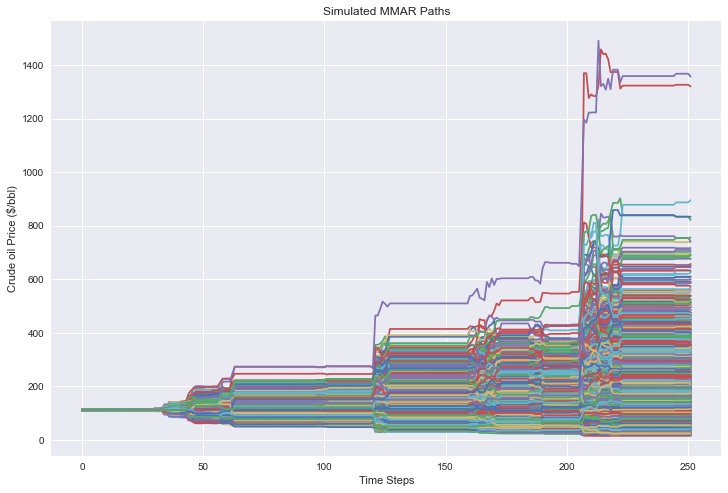

In [415]:
def plot_mmar_paths(paths):
    plt.figure(figsize=(12, 8))
    
    for path in paths:
        plt.plot(path)
    
    plt.title('Simulated MMAR Paths')
    plt.xlabel('Time Steps')
    plt.ylabel('Crude oil Price ($/bbl)')
    plt.grid(True)
    plt.show()
    
plot_mmar_paths(prices_paths)

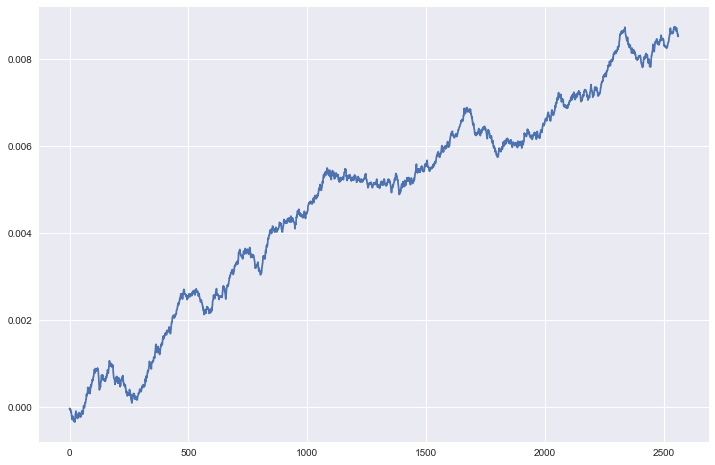

In [416]:
plt.figure(figsize=(12, 8))
plt.plot(new_fbm_simulation)
plt.show()

Secondly, we'll produce the trading time part of the stochastic process. Remember that the MMAR proposes a compound FBM/Trading Time stochastic process.

C:\Users\EricaKo\AppData\Local\Temp\ipykernel_24324\171127369.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


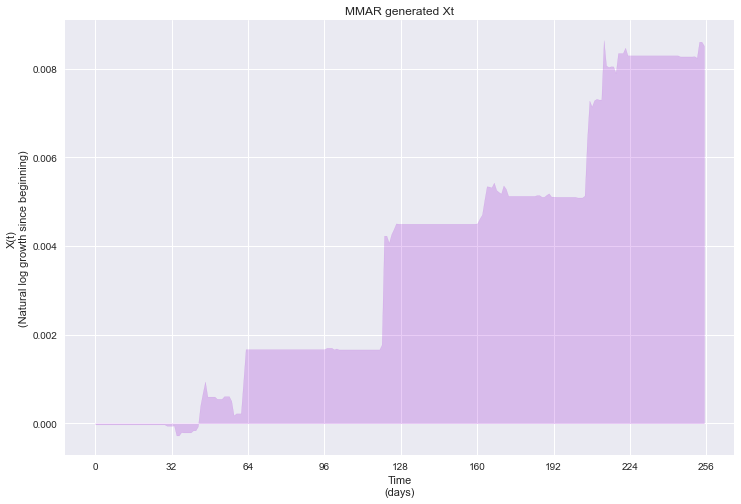

In [417]:
# --- MMAR returns's ---
simulated_xt_array = [0 for x in range(0, len(tradingtime))]

for i in range(0, len(tradingtime)):
    simulated_xt_array[i] = new_fbm_simulation[int(tradingtime[i]*10)]
    
plt.figure(figsize=(12, 8))
plt.title("MMAR generated Xt")
plt.xticks(np.arange(0, 2**(K)+1, 2**(K-3)))
plt.xlabel("Time\n(days)")
plt.ylabel('X(t)\n(Natural log growth since beginning)')
plt.grid(b=True)
plt.fill_between(np.arange(0, 2**K, 1) , simulated_xt_array, color="darkviolet", alpha=0.2)
plt.show()

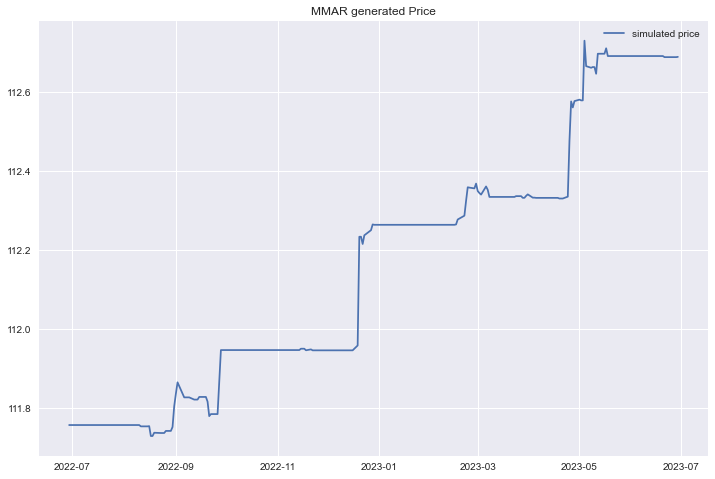

In [418]:
# --- PRICES ---
simulated_prices_array = prices_data_train.values[-1]*np.exp(simulated_xt_array[:len(prices_data_test)])
compound_process = pd.Series(simulated_prices_array, index=prices_data_test.index)
plt.figure(figsize=(12, 8))
plt.plot(compound_process, label='simulated price')
plt.title("MMAR generated Price")
plt.legend()

#### 5.6. Estimating the Option Payoff

In [419]:
# parameters
S0 = prices_data_train.values[-1]  
strike_p = S0
r = 0.05
T = 1.0

In [420]:
def option_pricer(paths, strike, r, T, option_type='call'):
    """
    Calculate the option price (european) given simulated paths.
    
    Parameters:
    - paths: An array of simulated asset paths. 
    - strike: Strike price of the option.
    - r: Risk-free rate.
    - T: Time to maturity in years.
    - option_type: call or put.
    
    Returns:
    - Option price
    """
    
    if isinstance(paths, list):
        paths = np.array(paths)
        
    # Get the asset prices at maturity (last column of paths matrix)
    S_T = paths[:, -1]
    
    # Calculate the payoff for each path
    if option_type == 'call':
        payoffs = np.maximum(S_T - strike, 0)
    elif option_type == 'put':
        payoffs = np.maximum(strike - S_T, 0)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
    
    # Average the payoffs and discount back to today
    option_price = np.exp(-r * T) * np.mean(payoffs)
    
    return option_price

In [421]:
print("Call option price: ", option_pricer(prices_paths, strike_p, r, T, option_type='call'))
print("Put option price: ", option_pricer(prices_paths, strike_p, r, T, option_type='put'))

Call option price:  44.539040125156035
Put option price:  18.941755999077447


In [425]:
def price_options_for_strikes(paths, center=80, step=5, num_strikes=5, r=0.05, T=1):
    """
    """

    option_prices = {}

    # Calculate prices for many strikes
    for i in range(1, num_strikes + 1):
        strike = center - i * step
        option_prices[strike] = option_pricer(paths, strike, r, T, option_type='put')

    # Calculate prices for strikes at and above the center
    for i in range(num_strikes + 1):
        strike = center + i * step
        option_prices[strike] = option_pricer(paths, strike, r, T, option_type='call')

    return option_prices

prices = price_options_for_strikes(prices_paths, center=110, step=5, num_strikes=6, r=r, T=T)
for strike, price in prices.items():
    print(f"Strike {strike}: Price {price:.2f}")

Strike 105: Price 15.82
Strike 100: Price 13.68
Strike 95: Price 11.71
Strike 90: Price 9.89
Strike 85: Price 8.24
Strike 80: Price 6.74
Strike 110: Price 45.38
Strike 115: Price 43.04
Strike 120: Price 40.83
Strike 125: Price 38.74
Strike 130: Price 36.76
Strike 135: Price 34.87
Strike 140: Price 33.08


We can observe that the prices generated by this model are not realistic. 

####  5.7 Alternative Paths Generator & Option Pricer 

In [91]:
close_return[-252:].std()*np.sqrt(252)

0.40278310574427056

Here, we are going to bring back the paths generated in '3.3. An Attempt at a More Sophisticated Multifractal Generator' and price options using that model:

In [100]:
MMAR_paths_trimmed = [arr[:-1] for arr in MMAR_paths]

In [101]:
def option_pricer(paths, strike, r, T, option_type='call'):
    """
    Calculate the option price (european) given simulated paths.
    
    Parameters:
    - paths: An array of simulated asset paths. 
    - strike: Strike price of the option.
    - r: Risk-free rate.
    - T: Time to maturity in years.
    - option_type: call or put.
    
    Returns:
    - Option price
    """
    
    if isinstance(paths, list):
        paths = np.array(paths)
        
    # Get the asset prices at maturity (last column of paths matrix)
    S_T = paths[:, -1]
    
    # Calculate the payoff for each path
    if option_type == 'call':
        payoffs = np.maximum(S_T - strike, 0)
    elif option_type == 'put':
        payoffs = np.maximum(strike - S_T, 0)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
    
    # Average the payoffs and discount back to today
    option_price = np.exp(-r * T) * np.mean(payoffs)
    
    return option_price

In [105]:
def price_options_for_strikes(paths, center=80, step=5, num_strikes=10, r=0.05, T=1):
    """
    """
    option_prices = {}

    # Calculate prices for put options (for strikes below the center)
    for i in range(1, num_strikes + 1):
        strike = center - i * step
        option_prices[(strike, 'put')] = option_pricer(paths, strike, r, T, option_type='put')

    # Calculate prices for call options (for strikes at and above the center)
    for i in range(num_strikes + 1):
        strike = center + i * step
        option_prices[(strike, 'call')] = option_pricer(paths, strike, r, T, option_type='call')

    return option_prices

# Assuming the previously defined 'paths', 'r', and 'T' are available
prices = price_options_for_strikes(MMAR_paths_trimmed, center=80, step=5, num_strikes=10, r=r, T=T)

# Sort by strike level and print
for (strike, option_type), price in sorted(prices.items()):
    print(f"{option_type.capitalize()} Option - Strike {strike}: Price {price:.2f}")

Put Option - Strike 30: Price 0.75
Put Option - Strike 35: Price 1.03
Put Option - Strike 40: Price 1.40
Put Option - Strike 45: Price 1.87
Put Option - Strike 50: Price 2.43
Put Option - Strike 55: Price 3.14
Put Option - Strike 60: Price 4.07
Put Option - Strike 65: Price 5.25
Put Option - Strike 70: Price 6.73
Put Option - Strike 75: Price 8.51
Call Option - Strike 80: Price 10.17
Call Option - Strike 85: Price 8.02
Call Option - Strike 90: Price 6.24
Call Option - Strike 95: Price 4.81
Call Option - Strike 100: Price 3.66
Call Option - Strike 105: Price 2.77
Call Option - Strike 110: Price 2.09
Call Option - Strike 115: Price 1.56
Call Option - Strike 120: Price 1.15
Call Option - Strike 125: Price 0.84
Call Option - Strike 130: Price 0.63


The prices above are a lot closer to the ones observed in the market (ATM at 10.117 vs 8.8 in the market). We were able to use one of the models we derived above (Binomial with Multifractal Volatility) and the approximate parameters to match market prices. We can also see that prices make sense in terms of distance from ATM. 

#### 6. Conclusion

The MMAR and the fractal theories applied to finance are extremely sophisticated and are more realistic representations of the characteristics of asset prices. However, given the model's burdensome methodology for estimation of parameters and sparse literature and documention, the adoption of the theory has lagged its potential. In this paper, we have found that from a theoretical perspective, the MMAR is a much more elegant way of describing asset prices and hence to model instruments derived of these assets of interest. However, from a pratictioner's perspective, the ease of Black and Scholes for option calculation is an extremely convenient feature. 
With some parameter calibration, we were able to devise a model capable of approximating market prices. This model could be expanded and improved and ultimately be used as a tool to price options that are not vanilla, listed options on the exchange, i.e exotic options priced by broker dealers and market markets. This is ultimately what a model similar to the ones we derived are useful for because listed options have prices that are transparent and easy to access. 
We also learned that another factor to consider when using more sophisticated models like Multifractal Models to derive option prices is the run time of the pricer. A simulation of 1000 paths of a Multifractal Model took us around 40 seconds while an FBM simulation with the same number of paths took around 5-10 seconds. Longer pricing times should also be a deterrent to use MMAR models to price vanilla, listed options. In the realm of exotic derivatives however, where pricing time is not an issue and the more realistic representation of stochastic process is something desirable, we believe MMAR models are very useful and should be in fact implemented.
In terms of modelling the parameters as per the original paper, we found that the methodology described is not of trivial implementation. We faced several issues when devising partition fuctions and the multifractal spectrum for example. We had trouble deriving realistic option prices following the original MMAR implementation. We were not able to find any implementation of the MMAR or Multifractal parameter estimation in python nor in any other open-sourced language.
In summary, we believe that as computational power increases, the usage of multifractal models should increase. There is certainly is a need for more research in the space, particularly for modelling and pricing of exotic derivatives. One interesting area of future development should be use of machine learning to derive the optimal multiplicative cascade function for a particular time series, as well as the calculation of the fractal parameters from a historical timeseries. 